In [74]:
import os
import random
import pandas as pd

import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import functools
from keras import backend as K
    
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import pad_sequences 
from tensorflow.python.keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, GRU, Bidirectional
from keras.optimizers import Adam
from keras.initializers import Constant

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
path = "amazon_reviews_cleaned.csv"

data = pd.read_csv(path, encoding="utf-8")
data = data.reindex(np.random.permutation(data.index))

print("Shape of data: ", data.shape)
data.head()

Shape of data:  (10000, 10)


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Score,Review
4916,429170,429171.0,B000LLKCV0,A9UTZIRC2SDJE,James forest Plastina,1.0,1.0,1.312157e+09,1.0,perfect dont usually leave review hot sauce co...
419,441228,441229.0,B000EVQWKC,A3MKEN6U5UGDWV,T. Wade,4.0,4.0,1.212365e+09,0.0,artificial sweetener bother bowel gummi bear c...
8406,536360,536361.0,B0051ZCNIQ,AQUHQFTQFB63R,"Blwessels ""Blwessels""",0.0,0.0,1.335398e+09,1.0,make beautiful dog beautiful 8 month old beagl...
1552,103830,103831.0,B0029YA8CA,ABKAYGZQHIU63,Cookie Lover,3.0,3.0,1.270858e+09,0.0,broken cooky second time order moravian cooky ...
237,307944,307945.0,B001BS4G6O,A3F8MYJJ0BZLFW,Jimmie D. Burnett,0.0,0.0,1.223078e+09,1.0,way hide pill gracie pill pocket great . graci...


In [3]:
# reviews_text = data["Text"].values
# reviews_title = data["Summary"].values
reviews = data["Review"].values
reviews_rating = data["Score"].values

In [4]:
reviews_rating

array([1., 0., 1., ..., 0., 0., 1.])

In [5]:
# nltk libraries

stop_words = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()

In [6]:
# returns the Part-Of-Speech(pos) tag which is required as an argument for
# lemmatizer for determiing the context of the word for lemmatization

def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):  
        return 'a' # adjective
    elif pos_tag.startswith('V'): 
        return 'v' # verb
    elif pos_tag.startswith('R'):
        return 'r' # adverb
    else:           
        return 'n' # fallback to noun

In [7]:
# performs all sorts of preprocessing on text

def preprocess_text(text):
    
    # lowercase the entire text
    text = text.lower()
    
    # remove all html tags from dataset
    text = re.sub(r'<.*?>',"",text)
    
    # Replace special characters and punctuation by a 
    # blank ( except for full stop(.))
    text = re.sub('[^a-z0-9 \.]', '', text)
    
    # split the text into words
    words = word_tokenize(text) 
    
    # remove stop words like to, an, the, of, over, his, her, there, their ...
    words = [w for w in words if w =="not" or not w in stop_words ]
    
    # get pos tagging for words, required by lemmatizer
    words_pos = pos_tag(words) 
    
    lemmatized_words = []
    
    for word, tag in words_pos:
        pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatiser.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)
    
    text = " ".join(lemmatized_words)
    
    
    return text

In [8]:
DATA_SIZE = reviews.size

# reviews = []
labels = np.zeros(DATA_SIZE)

In [9]:
for i in range(DATA_SIZE):

    rating = reviews_rating[i]
    
    if(rating == 1.0):
        labels[i] = 1 # Positive Review (1)

In [10]:
labels

array([1., 0., 1., ..., 0., 0., 1.])

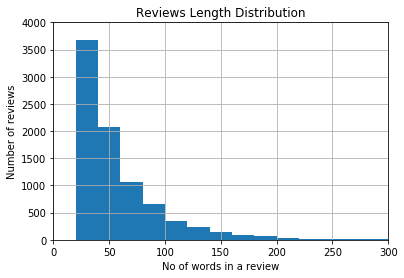

In [11]:
# plot showing lengthwise distribution of reviews

bins = [20*i for i in range(1, 30)]

plt.hist([len(s.split()) for s in reviews], bins=bins)

plt.xlabel('No of words in a review')
plt.ylabel('Number of reviews')
plt.title('Reviews Length Distribution') 

plt.axis([0, 300, 0, 4000])
plt.grid(True)

plt.show()

In [12]:
review_texts = []
review_labels = []

THRESHOLD_WORDS =70

In [13]:
# considering only those reviews whose length <= (THRESHOLD_WORDS = 60)


for idx, review in enumerate(reviews):
    
    if(len(review.split()) <= THRESHOLD_WORDS):
        review_texts.append(review)
        review_labels.append(labels[idx])
        

In [14]:
review_labels = np.array(review_labels)

In [15]:
NEW_DATA_SIZE = review_labels.shape[0]

In [16]:
# TRAIN - VALIDATION - TEST SPLIT

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TRAIN_INDEX = int(TRAIN_RATIO*NEW_DATA_SIZE)
VAL_INDEX = TRAIN_INDEX + int(VAL_RATIO*NEW_DATA_SIZE)

train_texts = review_texts[:TRAIN_INDEX]
y_train = review_labels[:TRAIN_INDEX]

val_texts = review_texts[TRAIN_INDEX:VAL_INDEX]
y_val = review_labels[TRAIN_INDEX:VAL_INDEX]

test_texts = review_texts[VAL_INDEX:]
y_test = review_labels[VAL_INDEX:]


<BarContainer object of 50 artists>

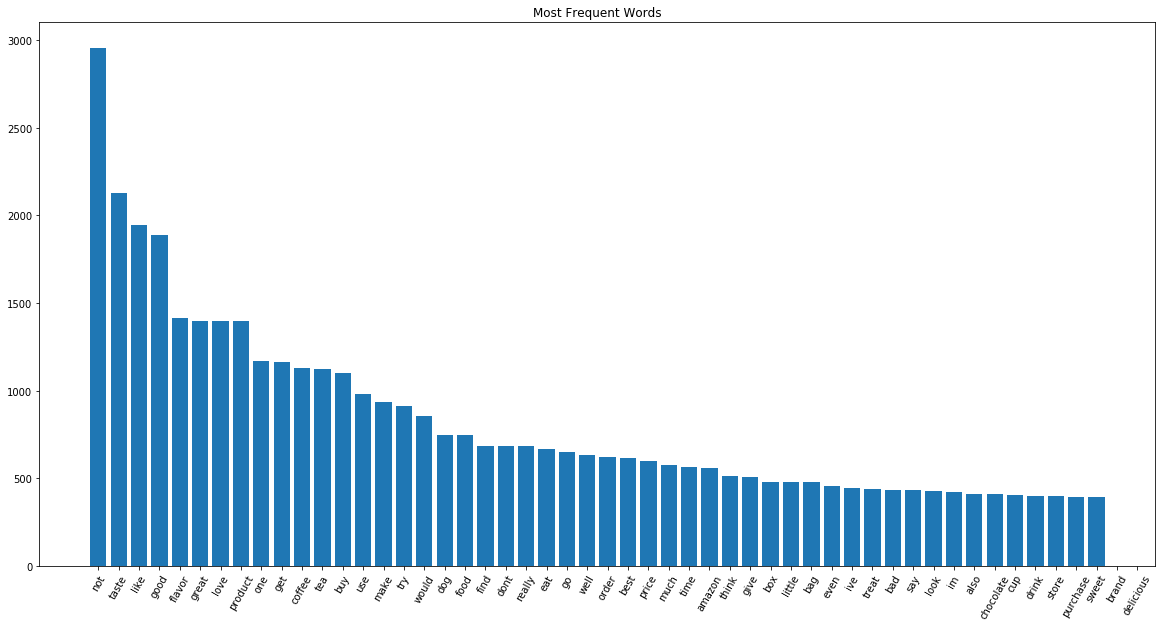

In [17]:
# tokenizing the reviews words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

MOST_K_FREQUENT = 100
TOP_K_FREQUENT = 50

def get_key(word_freq_pair):
    word, freq = word_freq_pair
    return freq
    
# MOST_K_FREQUENT WORDS
frequent_words = sorted(list(tokenizer.word_counts.items()), key = get_key, reverse = True)[:MOST_K_FREQUENT]

x = [i for i in range(MOST_K_FREQUENT)]
x_words = []
y_word_freq = []

for word, count in frequent_words:
    x_words.append(word)
    y_word_freq.append(count)

# plot showing most occuring words in the dataset    

mpl.rcParams['figure.figsize'] = (20,10)

plt.xticks(x, x_words)
plt.xticks(rotation=60)

plt.title("Most Frequent Words")

plt.bar(x[:TOP_K_FREQUENT], y_word_freq[:TOP_K_FREQUENT])

In [18]:
# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = THRESHOLD_WORDS

# Create vocabulary with training texts.
# By default, all punctuation is removed
tokenizer = Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_texts)

# Vectorize training and validation texts.
x_train = tokenizer.texts_to_sequences(train_texts)
x_val = tokenizer.texts_to_sequences(val_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

# Fix sequence length to MAX_SEQUENCE_LENGTH. Sequences shorter than the length are
# padded and sequences longer are truncated
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    

In [19]:

# creating dictionary of words containing corresponding word embeddings

filename = "glove.6B.100d.txt"

embeddings_index = {}

f = open(filename,  encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
    
f.close()


In [20]:

# dimension of each word embedding
EMBEDDING_DIM = 100

# creating embedding matrix for directly feeding to Embedding() layer of Keras

num_words = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    
    if i > num_words:
        continue
        
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

In [21]:
model_pretrained_glove = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glove.add(embedding_layer)
model_pretrained_glove.add(Dropout(0.3))

model_pretrained_glove.add(Conv1D(32, 5, activation='relu'))
model_pretrained_glove.add(MaxPooling1D(pool_size=4))
model_pretrained_glove.add(Dropout(0.2))

model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
model_pretrained_glove.add(MaxPooling1D(pool_size=4))
model_pretrained_glove.add(Dropout(0.2))
model_pretrained_glove.add(BatchNormalization())

model_pretrained_glove.add(Flatten())

model_pretrained_glove.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glove.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glove.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 100)           1100700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 66, 32)            16032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 32)            0         
__________________________________________________________

In [22]:

# training the model
model_pretrained_glove_history = model_pretrained_glove.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val, y_val))


Train on 4728 samples, validate on 1576 samples
Epoch 1/30
4728/4728 [==============================] - 10s 2ms/step - loss: 0.7351 - acc: 0.5696 - val_loss: 0.6192 - val_acc: 0.6720
Epoch 2/30
4728/4728 [==============================] - 3s 635us/step - loss: 0.5982 - acc: 0.6920 - val_loss: 0.5424 - val_acc: 0.7208
Epoch 3/30
4728/4728 [==============================] - 3s 667us/step - loss: 0.5514 - acc: 0.7303 - val_loss: 0.5054 - val_acc: 0.7786
Epoch 4/30
4728/4728 [==============================] - 4s 775us/step - loss: 0.5136 - acc: 0.7477 - val_loss: 0.4744 - val_acc: 0.7843
Epoch 5/30
4728/4728 [==============================] - 3s 632us/step - loss: 0.4863 - acc: 0.7621 - val_loss: 0.4776 - val_acc: 0.7817
Epoch 6/30
4728/4728 [==============================] - 3s 643us/step - loss: 0.4728 - acc: 0.7728 - val_loss: 0.4449 - val_acc: 0.8001
Epoch 7/30
4728/4728 [==============================] - 3s 649us/step - loss: 0.4503 - acc: 0.7906 - val_loss: 0.4333 - val_acc: 0.8020
E

In [24]:
# model history parameters

history = model_pretrained_glove_history.history

train_accuracy = history['acc']
train_loss = history['loss']

val_accuracy = history['val_acc']
val_loss = history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

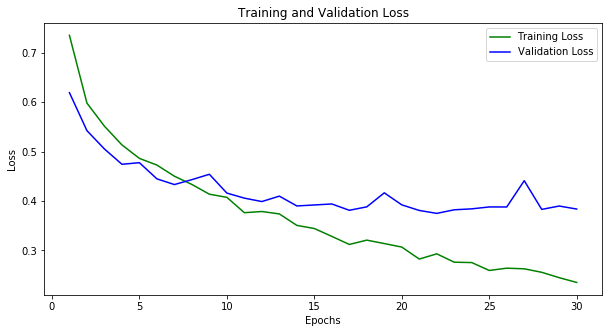

In [25]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

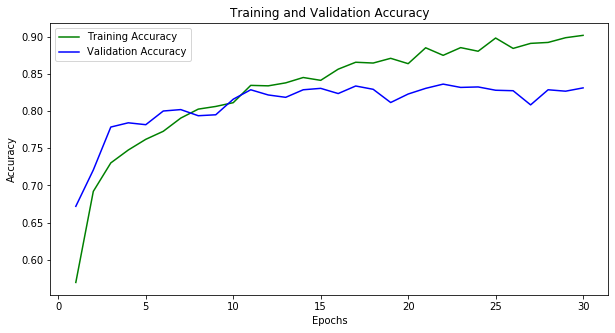

In [26]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [27]:
# evaluating the model on test dataset
model_pretrained_glove.evaluate(x_test, y_test)

1577/1577 [==============================] - 0s 183us/step


[0.4101278826490413, 0.8325935320984206]

In [71]:
model_pretrained_glovel = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glovel.add(embedding_layer)
model_pretrained_glovel.add(Dropout(0.3))

model_pretrained_glovel.add(LSTM(64, return_sequences=True, activation='relu'))
model_pretrained_glovel.add(Dropout(0.2))

model_pretrained_glovel.add(LSTM(128, return_sequences=True, activation='tanh'))
model_pretrained_glovel.add(Dropout(0.2))

model_pretrained_glovel.add(LSTM(128, activation='relu'))
model_pretrained_glovel.add(Dropout(0.2))

model_pretrained_glovel.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glovel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glovel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 70, 100)           1100700   
_________________________________________________________________
dropout_65 (Dropout)         (None, 70, 100)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 70, 64)            42240     
_________________________________________________________________
dropout_66 (Dropout)         (None, 70, 64)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 70, 128)           98816     
_________________________________________________________________
dropout_67 (Dropout)         (None, 70, 128)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 128)               131584    
__________

In [54]:
# training the model
model_pretrained_glove_historyl = model_pretrained_glovel.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val))

Train on 4728 samples, validate on 1576 samples
Epoch 1/15
4728/4728 [==============================] - 9s 2ms/step - loss: 0.5975 - acc: 0.6868 - val_loss: 0.5928 - val_acc: 0.7062
Epoch 2/15
4728/4728 [==============================] - 10s 2ms/step - loss: 0.5645 - acc: 0.7147 - val_loss: 0.5212 - val_acc: 0.7525
Epoch 3/15
4728/4728 [==============================] - 9s 2ms/step - loss: 0.5295 - acc: 0.7367 - val_loss: 0.5116 - val_acc: 0.7513
Epoch 4/15
4728/4728 [==============================] - 10s 2ms/step - loss: 0.4968 - acc: 0.7644 - val_loss: 0.4928 - val_acc: 0.7652
Epoch 5/15
4728/4728 [==============================] - 8s 2ms/step - loss: 0.4635 - acc: 0.7864 - val_loss: 0.5312 - val_acc: 0.7170
Epoch 6/15
4728/4728 [==============================] - 9s 2ms/step - loss: 0.4495 - acc: 0.7889 - val_loss: 0.4694 - val_acc: 0.7811
Epoch 7/15
4728/4728 [==============================] - 8s 2ms/step - loss: 0.4488 - acc: 0.7929 - val_loss: 0.4484 - val_acc: 0.7957
Epoch 8/15
4

In [55]:
# model history parameters

historyl = model_pretrained_glove_historyl.history

train_accuracy = historyl['acc']
train_loss = historyl['loss']

val_accuracy = historyl['val_acc']
val_loss = historyl['val_loss']

epochs = range(1, len(train_accuracy) + 1)

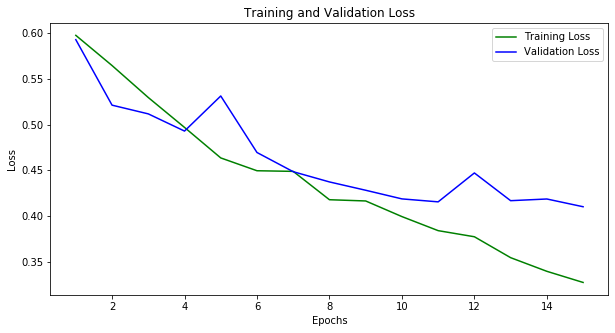

In [56]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

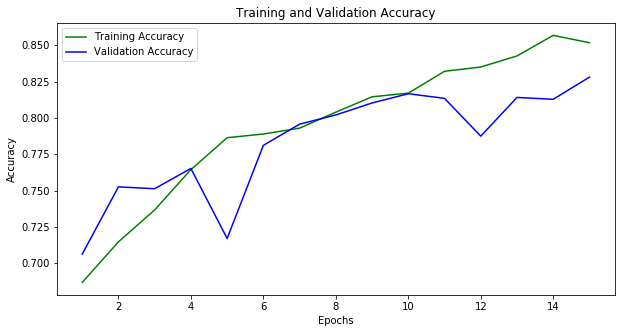

In [57]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [59]:
# evaluating the model on test dataset
model_pretrained_glovel.evaluate(x_test, y_test)

1577/1577 [==============================] - 1s 801us/step


[0.38770752633079064, 0.8325935320606244]

In [72]:
model_pretrained_glovel = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glovel.add(embedding_layer)
model_pretrained_glovel.add(Dropout(0.3))

model_pretrained_glovel.add(LSTM(64, return_sequences=True, activation='relu'))
model_pretrained_glovel.add(Dropout(0.2))

model_pretrained_glovel.add(LSTM(128, return_sequences=True,activation='tanh'))
model_pretrained_glovel.add(Dropout(0.2))

model_pretrained_glovel.add(GRU(128, activation='relu'))
model_pretrained_glovel.add(Dropout(0.2))

model_pretrained_glovel.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glovel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glovel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 70, 100)           1100700   
_________________________________________________________________
dropout_69 (Dropout)         (None, 70, 100)           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 70, 64)            42240     
_________________________________________________________________
dropout_70 (Dropout)         (None, 70, 64)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 70, 128)           98816     
_________________________________________________________________
dropout_71 (Dropout)         (None, 70, 128)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
__________

In [61]:
# training the model
model_pretrained_glove_historyl = model_pretrained_glovel.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val))

Train on 4728 samples, validate on 1576 samples
Epoch 1/15
4728/4728 [==============================] - 29s 6ms/step - loss: 0.7294 - acc: 0.5738 - val_loss: 0.6177 - val_acc: 0.6675
Epoch 2/15
4728/4728 [==============================] - 13s 3ms/step - loss: 0.6137 - acc: 0.6720 - val_loss: 0.5430 - val_acc: 0.7398
Epoch 3/15
4728/4728 [==============================] - 11s 2ms/step - loss: 0.5512 - acc: 0.7269 - val_loss: 0.5093 - val_acc: 0.7608
Epoch 4/15
4728/4728 [==============================] - 10s 2ms/step - loss: 0.5187 - acc: 0.7445 - val_loss: 0.4912 - val_acc: 0.7621
Epoch 5/15
4728/4728 [==============================] - 13s 3ms/step - loss: 0.4846 - acc: 0.7684 - val_loss: 0.4557 - val_acc: 0.7906
Epoch 6/15
4728/4728 [==============================] - 11s 2ms/step - loss: 0.4765 - acc: 0.7756 - val_loss: 0.4491 - val_acc: 0.7963 loss: 
Epoch 7/15
4728/4728 [==============================] - 12s 3ms/step - loss: 0.4447 - acc: 0.7940 - val_loss: 0.4406 - val_acc: 0.7989


In [62]:
# model history parameters

historyl = model_pretrained_glove_historyl.history

train_accuracy = historyl['acc']
train_loss = historyl['loss']

val_accuracy = historyl['val_acc']
val_loss = historyl['val_loss']

epochs = range(1, len(train_accuracy) + 1)

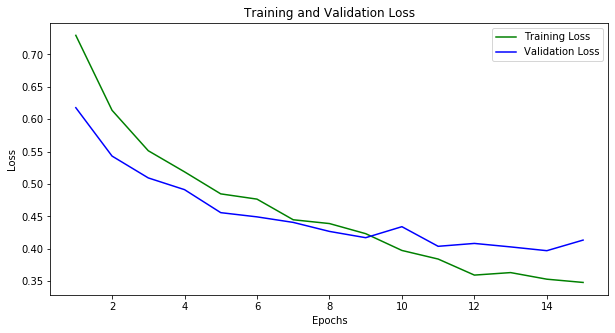

In [63]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

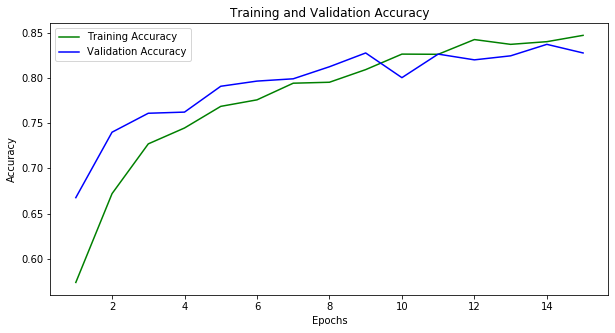

In [64]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [ ]:
# evaluating the model on test dataset
model_pretrained_glovel.evaluate(x_test, y_test)

In [82]:
model_pretrained_glove = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glove.add(embedding_layer)
model_pretrained_glove.add(Dropout(0.3))

model_pretrained_glove.add(LSTM(64, return_sequences=True, activation='relu'))
model_pretrained_glove.add(Dropout(0.2))

model_pretrained_glove.add(LSTM(128, return_sequences=True,activation='tanh'))
model_pretrained_glove.add(Dropout(0.2))

model_pretrained_glove.add(Bidirectional(LSTM(128,activation='relu')))
model_pretrained_glove.add(Dropout(0.2))

model_pretrained_glove.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glove.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 70, 100)           1100700   
_________________________________________________________________
dropout_76 (Dropout)         (None, 70, 100)           0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 70, 64)            42240     
_________________________________________________________________
dropout_77 (Dropout)         (None, 70, 64)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 70, 128)           98816     
_________________________________________________________________
dropout_78 (Dropout)         (None, 70, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
__________

In [77]:
# training the model
model_pretrained_glove_history = model_pretrained_glove.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val))

Train on 4728 samples, validate on 1576 samples
Epoch 1/15
4728/4728 [==============================] - 25s 5ms/step - loss: 0.7519 - acc: 0.5649 - val_loss: 0.6190 - val_acc: 0.6567
Epoch 2/15
4728/4728 [==============================] - 12s 3ms/step - loss: 0.6264 - acc: 0.6739 - val_loss: 0.5612 - val_acc: 0.7138
Epoch 3/15
4728/4728 [==============================] - 13s 3ms/step - loss: 0.5752 - acc: 0.7104 - val_loss: 0.5516 - val_acc: 0.7043
Epoch 4/15
4728/4728 [==============================] - 10s 2ms/step - loss: 0.5274 - acc: 0.7367 - val_loss: 0.5036 - val_acc: 0.7621
Epoch 5/15
4728/4728 [==============================] - 10s 2ms/step - loss: 0.4961 - acc: 0.7574 - val_loss: 0.4932 - val_acc: 0.7741
Epoch 6/15
4728/4728 [==============================] - 10s 2ms/step - loss: 0.4778 - acc: 0.7769 - val_loss: 0.4770 - val_acc: 0.7633
Epoch 7/15
4728/4728 [==============================] - 10s 2ms/step - loss: 0.4618 - acc: 0.7870 - val_loss: 0.4425 - val_acc: 0.8020
Epoch 8

In [78]:
# model history parameters

historyl = model_pretrained_glove_historyl.history

train_accuracy = historyl['acc']
train_loss = historyl['loss']

val_accuracy = historyl['val_acc']
val_loss = historyl['val_loss']

epochs = range(1, len(train_accuracy) + 1)

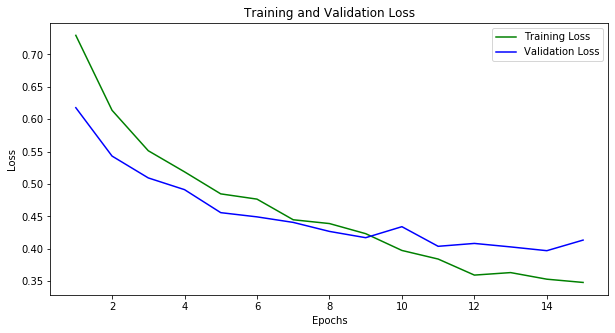

In [79]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

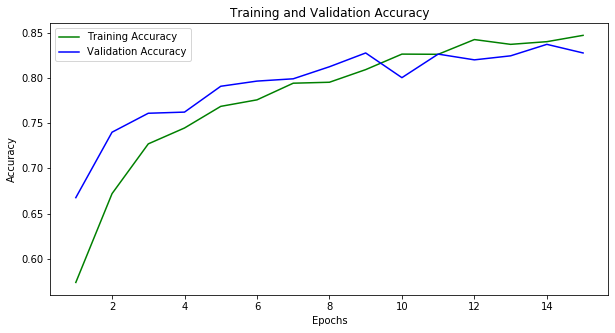

In [80]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()